# CNN-LSTM

Information...

## Load packages

In [1]:
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
sys.path.append('../scripts')
from CNN import CNNBlock

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Input, Embedding, Concatenate, Dense, Flatten, Dropout, LSTM

## Data

In [4]:
combos = os.listdir('../data/complete_weather')
complete_combos = []
count=0
for c in combos:
    pth = os.path.join('..', 'data', 'complete_weather', c)
    df = pd.read_csv(pth)
    n_missing = df.shape[0] - df.dropna().shape[0]
    if n_missing == 0:
        complete_combos.append(c)
    elif df.shape[0] == n_missing:
        count += 1
    else:
        print(c + '; days missing weather: ' + str(n_missing))

columbia valley-1999.csv; days missing weather: 12
willamette valley-2018.csv; days missing weather: 3
carneros-2000.csv; days missing weather: 10
north coast-2000.csv; days missing weather: 17
columbia valley-1997.csv; days missing weather: 174
RRV-2000.csv; days missing weather: 17
sonoma-2000.csv; days missing weather: 17
napa-2000.csv; days missing weather: 10


In [5]:
df = pd.read_csv('../data/wine_data_final.csv')
df = df[df.file.isin(complete_combos)]
print(df.shape)
df.head()

(188, 3)


,skin,file,quality
0,1,RRV-2008.csv,91.0
1,1,RRV-2020.csv,92.5
5,1,RRV-2009.csv,88.5
6,0,sonoma-2009.csv,88.0
7,1,sonoma-2009.csv,91.0


In [6]:
np.random.seed(34)
ids = set(df.index.tolist())
test = set(df.sample(n=20).index.tolist())
train = ids - test
val = set(df.loc[ids, :].sample(n=15).index.tolist())
train = train - val

In [7]:
df_train = df.loc[train, :]
df_val = df.loc[val, :]
df_test = df.loc[test, :]

s_train = df_train.skin.values
gt_train = df_train.quality.values

s_val = df_val.skin.values
gt_val = df_val.quality.values

s_test = df_test.skin.values
gt_test = df_test.quality.values

In [8]:
def fetch_weather(x):
    pth = os.path.join('..', 'data', 'complete_weather', x)
    weather = pd.read_csv(pth)
    return weather.values

def compile_weather(data, xs):
    for i, x in enumerate(xs):
        f = data.loc[x, 'file']
        if i == 0:
            n1 = fetch_weather(f)
        else:
            n2 = fetch_weather(f)
            n1 = np.concatenate((n1, n2), axis=0)
    return n1.reshape(i+1,245,7)

In [9]:
w_train = compile_weather(df, train)
w_val = compile_weather(df, val)
w_test = compile_weather(df, test)

## Create model

In [103]:
lr = 5e-3
decay = ExponentialDecay(lr, decay_steps=1000, decay_rate=0.98)
adam_decay = Adam(decay)

earlystopping = EarlyStopping(min_delta=0.0, patience=20)

In [104]:
weather_input = Input(shape=(245,7))

cnn = CNNBlock()
x = cnn(weather_input)
x = LSTM(8, activation='relu')(x)
x = Dense(1, activation='relu')(x)

In [105]:
model = Model(inputs=weather_input, outputs=x)
model.compile(loss='mean_squared_error', optimizer=adam_decay)

## Train / Test Model

In [106]:
model.fit(x=w_train, y=gt_train, validation_data=(w_val, gt_val),
          epochs=1000, callbacks=[earlystopping])

Epoch 1/1000
5/5 [==============================] - 1s 108ms/step - loss: 44569.8047 - val_loss: 4736.3525
Epoch 2/1000
5/5 [==============================] - 0s 76ms/step - loss: 4649.9458 - val_loss: 2971.4846
Epoch 3/1000
5/5 [==============================] - 0s 86ms/step - loss: 2033.9988 - val_loss: 764.2705
Epoch 4/1000
5/5 [==============================] - 0s 82ms/step - loss: 337.8019 - val_loss: 636.6532
Epoch 5/1000
5/5 [==============================] - 0s 78ms/step - loss: 571.7006 - val_loss: 223.5692
Epoch 6/1000
5/5 [==============================] - 0s 80ms/step - loss: 127.5964 - val_loss: 275.8088
Epoch 7/1000
5/5 [==============================] - 0s 81ms/step - loss: 240.0989 - val_loss: 113.0948
Epoch 8/1000
5/5 [==============================] - 0s 78ms/step - loss: 88.7989 - val_loss: 195.6386
Epoch 9/1000
5/5 [==============================] - 0s 78ms/step - loss: 127.4701 - val_loss: 99.6286
Epoch 10/1000
5/5 [==============================] - 0s 75ms/step - 

5/5 [==============================] - 0s 68ms/step - loss: 19.3089 - val_loss: 17.5000
Epoch 82/1000
5/5 [==============================] - 0s 77ms/step - loss: 20.8289 - val_loss: 15.2023
Epoch 83/1000
5/5 [==============================] - 0s 65ms/step - loss: 20.3792 - val_loss: 23.5462
Epoch 84/1000
5/5 [==============================] - 0s 73ms/step - loss: 19.0187 - val_loss: 18.6293
Epoch 85/1000
5/5 [==============================] - 0s 70ms/step - loss: 17.1563 - val_loss: 16.2430
Epoch 86/1000
5/5 [==============================] - 0s 69ms/step - loss: 16.9535 - val_loss: 16.1219
Epoch 87/1000
5/5 [==============================] - 0s 71ms/step - loss: 16.8899 - val_loss: 24.9781
Epoch 88/1000
5/5 [==============================] - 0s 63ms/step - loss: 17.5076 - val_loss: 15.7191
Epoch 89/1000
5/5 [==============================] - 0s 66ms/step - loss: 17.6039 - val_loss: 12.6005
Epoch 90/1000
5/5 [==============================] - 0s 64ms/step - loss: 21.1170 - val_loss: 22

### Testing

In [107]:
# preds = model.predict([s_test, w_test]).T[0]
preds = model.predict(w_test).T[0]

In [108]:
def pred_lim(x):
    if x > 100: 
        return 100
    else:
        return x

In [109]:
res = pd.DataFrame({'pred':preds, 'true': gt_test})
res.pred = res.pred.apply(pred_lim)
res.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
pred,92.062668,92.652992,92.231796,88.723137,91.088913,91.742027,92.221329,91.360558,88.821381,95.208153,94.938293,88.794884,92.947952,94.501366,93.932144,90.500908,85.332619,88.594841,90.290726,84.497314
true,92.000000,90.000000,89.000000,93.000000,94.000000,94.500000,90.000000,94.000000,89.000000,95.000000,92.000000,86.500000,93.000000,93.000000,94.000000,91.000000,85.000000,92.500000,92.500000,86.000000


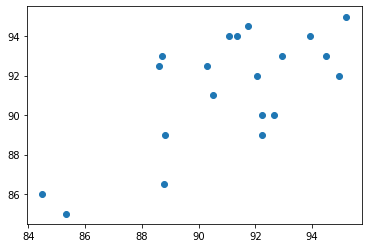

In [110]:
plt.scatter(res.pred, res.true)
plt.show()

In [111]:
corr, _ = pearsonr(res.pred, res.true)

In [112]:
corr

0.6880012799169649

In [113]:
np.sqrt(np.sum((res.pred - res.true)**2)/res.shape[0])

2.2665592350707127